# Linear Classifier of Math-operators
In this notebook we build the linear classifier for the mathematical operators.  
Its safe to say this is quite overfitted on the operators we are given, but we accept this as its works on the usecase.

In [11]:
import os
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from torchvision import transforms, utils
import torchvision.transforms.functional as TF
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
class OperatorsDataset(Dataset):
    """ Custom Dataset for Operators"""
    
    def __init__(self, root_dir, csv_file, transform = None, grayscale = True):
        
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.grayscale = grayscale
        
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx].path)
        image = Image.open(img_name)

        label = self.dataframe.loc[idx].label
        
        if self.transform:
            sample = self.transform(image)
        
        image = np.asarray(image)        
        if self.grayscale:
            image = rgb2gray(image)
            
        image = image.astype(np.float32)

        return (image, label)

train_dataset = OperatorsDataset("./data/train", "./data/train/datasheet.csv", 
                           transform = transforms.Compose([transforms.RandomRotation(180),
                                                           transforms.ToTensor(), 
                                                           transforms.Normalize(0.1307, 0.3081)]))
test_dataset = OperatorsDataset("./data/operators_test", "./data/operators_test/datasheet.csv", 
                           transform = transforms.Compose([transforms.ToTensor(), 
                                                           transforms.Normalize(0.1307, 0.3081)]))

In [13]:

def get_dataloaders(dataset,
        batch_size = 64,
        valid_size = 0.2,
        shuffle = True,
        random_seed = 1):

    num_train = len(dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler,
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=valid_sampler,
    )
    return train_loader, valid_loader

train_loader, valid_loader = get_dataloaders(train_dataset)



In [14]:
class OperatorNet(nn.Module):
    def __init__(self):
        """ Init """
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = 3, kernel_size= 3, padding= 1)
        self.maxpool = nn.MaxPool2d(kernel_size= 2, stride= 2)
        self.conv2 = nn.Conv2d(in_channels= 3, out_channels = 10, kernel_size= 3, padding= 1)
        self.fc1 = nn.Linear(10*22*22, 50)
        self.fc2 = nn.Linear(50,14)
        
    def forward(self, x):
        """ Forward pass """
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10*22*22)
        x = self.fc1(x)
        #x = self.fc2(x)
        return x
        
    def predict(self, x):
        """ Returns softmaxed labels"""
        
        x = self.forward(x)
        return F.softmax(x)


In [15]:
def validate_on_dataloader(net, dataloader):
    """
    Returns accuracy on a given dataloader given net
    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():    
        for images, labels in dataloader:
            #images.resize_(images.size()[0], 1024)
            images = images.unsqueeze(1)

            output = net(images)
            predicted = (F.softmax(output).data).max(1)[1]
            correct += (labels == predicted).sum().item()
            total += labels.size(0)

    return 100*(correct/total)

In [16]:
net = OperatorNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,50,80], gamma=0.5)

epochs = 5
eval_every = 1
print_every = 1
train_accs = []
val_accs = []

for e in range(epochs): 
    running_loss = 0
    
    for images, labels in iter(train_loader):
        
        #images.resize_(images.size()[0], 1024)
        optimizer.zero_grad()
        
        images = images.unsqueeze(1)
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if e % eval_every == 0:
        
        accuracy_train = validate_on_dataloader(net, train_loader)
        accuracy_val = validate_on_dataloader(net, valid_loader)
        train_accs.append(accuracy_train)
        val_accs.append(accuracy_val)
        
        if e % print_every == 0:
            print("\n----------------------------------------")
            print("EPOCH {}".format(e))
            print("Loss on current epoch: {}".format(running_loss))
            print("Accuracy on train set {}".format(np.around(accuracy_train, 2)))
            print("Accuracy on validation set {}".format(np.around(accuracy_val, 2)))
            print("----------------------------------------")
    
    scheduler.step()


IndexError: too many indices for array

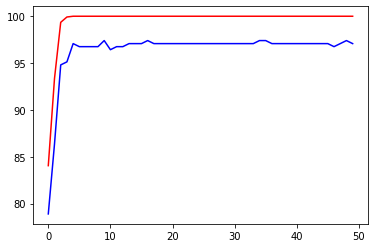

In [7]:
def plot_training(train_accs, val_accs):
    """ Plots val and train accurcacy """
    x = range(len(train_accs))
    plt.plot(x, train_accs, color = "red")
    plt.plot(x, val_accs, color = "blue")
    
    plt.show()
    
plot_training(train_accs, val_accs)
    

In [8]:
import time
torch.save(net.state_dict(), "./weights/model_at_{}.ckpt".format(np.around(time.time(), 2)))

In [9]:
def predict_on_single_image(net, img):
    """ Plots image and gives prediction"""
    label_map = {0: "Plus", 1: "Minus", 2: "Multiplication", 3: "Divide", 4: "Equals"}
    
    # Make sure all imgs are same format
    try:
        img = img.resize(1, 32, 32)
    except:
        print("Unaccepted shape for image")
    
    plt.imshow(img.resize(32, 32), cmap= "Greys")
    plt.show()
    
    output = net(img.unsqueeze(0))
    pred = (F.softmax(output).data).max(1)[1]
    print('Predicted:', label_map[pred.item()])
    
    


Label: Minus


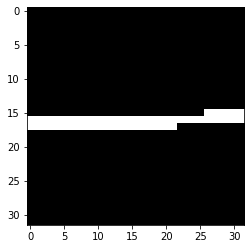

Predicted: Minus


In [10]:
label_map = {0: "Plus", 1: "Minus", 2: "Multiplication", 3: "Divide", 4: "Equals"}

dataiter = iter(valid_loader)
images, labels = dataiter.next()
img_nr = np.random.randint(4, size = 1)
img, label = images[img_nr], labels[img_nr]

print('Label:', label_map[label.item()])

predict_on_single_image(net, img)


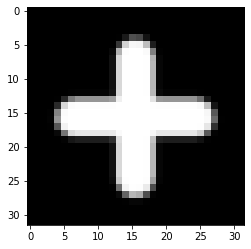

Predicted: Plus


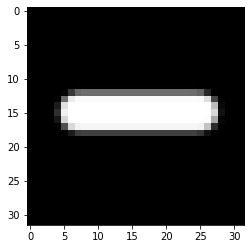

Predicted: Minus


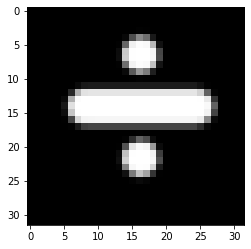

Predicted: Divide


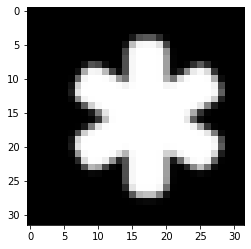

Predicted: Multiplication


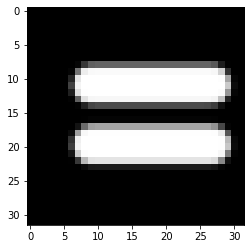

Predicted: Equals


In [11]:
import time
from utils import get_operators_from_original

op_tensors = get_operators_from_original()

for image in op_tensors:
    predict_on_single_image(net, image)
    time.sleep(1)

In [12]:
test_dataset = OperatorsDataset("./data/operators_test", "./data/operators_test/datasheet.csv", 
                           transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]))

test_dataloader, _ = get_dataloaders(test_dataset,
        batch_size = 4,
        valid_size = 0,
        shuffle = True,
        random_seed = 1)

from utils import update_datasheet

update_datasheet(image_dir = "./data/operators_test/")

In [13]:
validate_on_dataloader(net, test_dataloader)

22.519083969465647

In [14]:
def theshold_test_img(img):
    img[img < 0.8] = 0
    return img
    


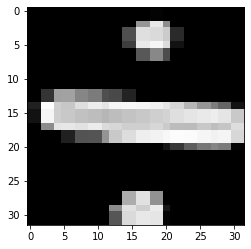

Predicted: Plus


'\nplt.imshow(image, cmap = "Greys")\noutput = net(image.resize(1, 1024))\nprint(F.softmax(output).data)\npred = (F.softmax(output).data).max(1)[1]\n#print(\'Predicted:\', label_map[pred.item()])\nplt.show()\n'

In [20]:
image = Image.open("./data/candidates_new/im12.png")
img = np.asarray(image)
image = rgb2gray(img)
#image = theshold_test_img(image)
image = torch.from_numpy(image.astype(np.float32))
image = transforms.functional.normalize(image.unsqueeze(0), 0.1307, 0.3081)

predict_on_single_image(net, image)

"""
plt.imshow(image, cmap = "Greys")
output = net(image.resize(1, 1024))
print(F.softmax(output).data)
pred = (F.softmax(output).data).max(1)[1]
#print('Predicted:', label_map[pred.item()])
plt.show()
"""